In [9]:
# import the tools needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

I import the file to be analyzed and view what is available.

In [11]:
# read in a data file to be used for analysis
moV = pd.read_csv('tmdb-movies.csv')
moV.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


I can see that there is a significant amount of imformation that will not be pertinent to my investigation. I will remove those columns

In [12]:
# remove columns that are not of interest
moV.drop(['tagline','keywords', 'cast', 'imdb_id', 'runtime', 'release_date', 'overview', 'vote_count', 'vote_average','homepage','budget_adj', 'revenue_adj'], axis=1, inplace=True)
moV.head()

,id,popularity,budget,revenue,original_title,director,genres,production_companies,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,George Miller,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015
2,262500,13.112507,110000000,295238201,Insurgent,Robert Schwentke,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015
4,168259,9.335014,190000000,1506249360,Furious 7,James Wan,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015


Inspection of the head doesn't reveal Na's however, I will assume there are some. I will remove any rows containing Na's in the genres column since that is the basis for my analysis.

In [13]:
moV = moV.dropna(axis=0, subset=['genres'])
sum(moV['genres']== 'Na')

0

I will fill any other Na's with 'unknown' 

In [14]:
moV.fillna('unknown', inplace=True)

Initial inspection revealed there are two columns of interest that contain multiple datum that I need to split. I will keep only the first datum assuming it is the most signicant

In [15]:
# split columns with multiple values keeping only the first datum
split_columns = ['genres', 'production_companies']
for c in split_columns:
    moV[c] = moV[c].apply(lambda x: x.split('|')[0])
moV.head()    

,id,popularity,budget,revenue,original_title,director,genres,production_companies,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Colin Trevorrow,Action,Universal Studios,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,George Miller,Action,Village Roadshow Pictures,2015
2,262500,13.112507,110000000,295238201,Insurgent,Robert Schwentke,Adventure,Summit Entertainment,2015
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,Action,Lucasfilm,2015
4,168259,9.335014,190000000,1506249360,Furious 7,James Wan,Action,Universal Pictures,2015


I am interested in profits so I will add a column that contains the difference between the 'revenue' and 'budget' columns

In [16]:
profit=moV['revenue']-moV['budget']
moV = pd.concat([moV,profit],axis=1,  sort=False)
moV = moV.rename(columns={moV.columns[-1]: 'profit'})
moV.head()

,id,popularity,budget,revenue,original_title,director,genres,production_companies,release_year,profit
0,135397,32.985763,150000000,1513528810,Jurassic World,Colin Trevorrow,Action,Universal Studios,2015,1363528810
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,George Miller,Action,Village Roadshow Pictures,2015,228436354
2,262500,13.112507,110000000,295238201,Insurgent,Robert Schwentke,Adventure,Summit Entertainment,2015,185238201
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,Action,Lucasfilm,2015,1868178225
4,168259,9.335014,190000000,1506249360,Furious 7,James Wan,Action,Universal Pictures,2015,1316249360


At this point I can start to manipulate the data for viewing

First I will group years 2010-2015 for use later

In [17]:
moV2010_2015 = moV[moV['release_year'] >= 2010]

I created a function to rename columns that have the same name so I can then properly name them

In [18]:
def column_rename_multiple_same(file,col_name):
    cols = []
    count = 1
    for column in file.columns:
        if column == col_name:
            cols.append(col_name + f'{count}')
            count+=1
            continue
        cols.append(column)
    
    file.columns = cols

I also created a function to split the year from the main file

In [20]:
def split_year(file, year):
        m = file[file['release_year'] == year]
        return m

Next I will be looking at each year from 2010-2015 seperately so I will split them now

In [22]:
movies10 = split_year(moV, 2010)
movies11 = split_year(moV, 2011)
movies12 = split_year(moV, 2012)
movies13 = split_year(moV, 2013)
movies14 = split_year(moV, 2014)
movies15 = split_year(moV, 2015)

I count each genre per year 

In [23]:
moV10 = movies10.groupby('genres').count()['id']
moV11 = movies11.groupby('genres').count()['id']
moV12 = movies12.groupby('genres').count()['id']
moV13 = movies13.groupby('genres').count()['id']
moV14 = movies14.groupby('genres').count()['id']
moV15 = movies15.groupby('genres').count()['id']

I group this information together. I fill Na's and check that it is what I expected

In [27]:
movies = pd.concat([moV10,moV11,moV12,moV13,moV14,moV15],axis=1, sort=False)
movies.fillna(0,inplace=True)  # I know there are Nan values that will cause problems
movies.head(2)

,id,id,id,id,id,id
Action,66.0,67.0,67.0,87.0,65.0,59.0
Adventure,19.0,31.0,20.0,17.0,29.0,20.0
Animation,34.0,28.0,26.0,28.0,15.0,13.0
Comedy,97.0,100.0,110.0,115.0,102.0,78.0
Crime,18.0,16.0,13.0,17.0,18.0,22.0


All column names are the same so I need to address that. First I add a count to their name, then change it to the proper year and verify changes.

In [29]:
column_rename_multiple_same(movies,'id')

movies.rename(columns={ 'id1':'2010','id2': "2011" , 'id3': "2012", 'id4':'2013', 'id5': '2014', 'id6':'2015'}, inplace=True)
movies.head(2)

,2010,2011,2012,2013,2014,2015
Action,66.0,67.0,67.0,87.0,65.0,59.0
Adventure,19.0,31.0,20.0,17.0,29.0,20.0


I want a list of the genres to use as labels

In [30]:
names = moV['genres'].unique()
name =names.tolist()
name.sort()

My first plot will show the amount of movies produced per year by genre

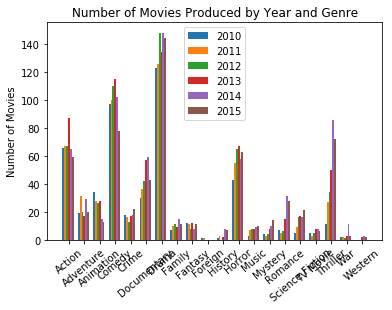

In [31]:
width = 0.12
index = np.arange(len(movies['2010']))

plt.bar(index,movies['2010'],width, label='2010')
plt.bar(index+ width, movies['2011'],width, label='2011')
plt.bar(index+(2*width), movies['2012'],width, label='2012')
plt.bar(index+(3*width), movies['2013'],width, label='2013')
plt.bar(index+(4*width), movies['2014'],width, label='2014')
plt.bar(index+(5*width), movies['2015'],width, label='2015')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Produced by Year and Genre')
plt.xticks( index+(3*width),name, rotation=40) 
plt.legend()
plt.show()


I see there is an issue with the spacing for the x-labels. I cannot come up with a reason. Your input would be appreciated.

Next I will look at the popularity per genre per year. I will split the data , then combine them into one series and take care of any Na's

In [32]:
moV10_pop = movies10.groupby('genres')['popularity'].mean()
moV11_pop = movies11.groupby('genres')['popularity'].mean()
moV12_pop = movies12.groupby('genres')['popularity'].mean()
moV13_pop = movies13.groupby('genres')['popularity'].mean()
moV14_pop = movies14.groupby('genres')['popularity'].mean()
moV15_pop = movies15.groupby('genres')['popularity'].mean()

In [33]:
movies_pop = pd.concat([moV10_pop,moV11_pop,moV12_pop,moV13_pop,moV14_pop,moV15_pop],axis=1, sort=False)
movies_pop.fillna(0,inplace=True)  # I know there are Nan values that will cause problems
movies_pop.head()

,popularity,popularity,popularity,popularity,popularity,popularity
Action,1.025166,1.012548,1.056954,0.969048,1.954755,2.881386
Adventure,1.600994,1.216805,1.105026,0.935867,2.363833,2.149264
Animation,0.595166,0.885230,0.885061,1.065841,0.815055,0.606748
Comedy,0.547223,0.671555,0.468286,0.544254,0.722765,0.923022
Crime,0.546363,0.541410,0.787069,0.835374,1.212061,1.824494


Again, I need to change the column names

In [34]:
column_rename_multiple_same(movies_pop,'popularity')
movies_pop.rename(columns={ 'popularity1':'2010','popularity2': "2011",'popularity3':'2012', 'popularity4':'2013', 'popularity5':'2014', 'popularity6':'2015',}, inplace=True)

Plot of popularity of genre per year

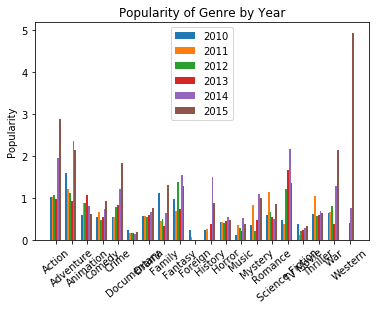

In [35]:
width = 0.12
index = np.arange(len(movies_pop))

plt.bar(index,movies_pop['2010'],width, label='2010')
plt.bar(index+ width, movies_pop['2011'],width, label='2011')
plt.bar(index+(2*width), movies_pop['2012'],width, label='2012')
plt.bar(index+(3*width), movies_pop['2013'],width, label='2013')
plt.bar(index+(4*width), movies_pop['2014'],width, label='2014')
plt.bar(index+(5*width), movies_pop['2015'],width, label='2015')
plt.ylabel('Popularity')
plt.title('Popularity of Genre by Year')
plt.xticks( index+(3*width),name, rotation=40)
plt.legend()
plt.show()


Now I'll look at the three most popular movies per year. First I identify them, then collect them into one series, and verify. There should be a total of 18, 3 per year.

In [36]:
look_at_popularity_10 = movies10.nlargest(3,['popularity'])
look_at_popularity_11 = movies11.nlargest(3,['popularity'])
look_at_popularity_12 = movies12.nlargest(3,['popularity'])
look_at_popularity_13 = movies13.nlargest(3,['popularity'])
look_at_popularity_14 = movies14.nlargest(3,['popularity'])
look_at_popularity_15 = movies15.nlargest(3,['popularity'])
TopPopular = pd.concat([look_at_popularity_10,look_at_popularity_11,look_at_popularity_12,look_at_popularity_13,look_at_popularity_14,look_at_popularity_15],axis=0, sort=False)
TopPopular

,id,popularity,budget,revenue,original_title,director,genres,production_companies,release_year,profit
1919,27205,9.363643,160000000,825500000,Inception,Christopher Nolan,Action,Legendary Pictures,2010,665500000
1920,10138,5.704860,200000000,623933331,Iron Man 2,Jon Favreau,Adventure,Marvel Studios,2010,423933331
1921,12155,5.572950,200000000,1025467110,Alice in Wonderland,Tim Burton,Family,Walt Disney Pictures,2010,825467110
3371,161337,8.411577,0,0,Underworld: Endless War,Juno John Lee,Action,unknown,2011,0
3372,1771,7.959228,140000000,370569774,Captain America: The First Avenger,Joe Johnston,Action,Marvel Studios,2011,230569774
3373,64690,5.903353,15000000,76175166,Drive,Nicolas Winding Refn,Drama,Bold Films,2011,61175166
4361,24428,7.637767,220000000,1519557910,The Avengers,Joss Whedon,Science Fiction,Marvel Studios,2012,1299557910
4362,52520,7.031452,70000000,132400000,Underworld: Awakening,MÃ¥ns MÃ¥rlind|BjÃ¶rn Stein,Fantasy,Lakeshore Entertainment,2012,62400000
4363,49026,6.591277,250000000,1081041287,The Dark Knight Rises,Christopher Nolan,Action,Legendary Pictures,2012,831041287
5422,109445,6.112766,150000000,1274219009,Frozen,Chris Buck|Jennifer Lee,Animation,Walt Disney Pictures,2013,1124219009


Now I would like to look at the genres of the most popular

In [37]:
TP10 = look_at_popularity_10.genres
TP11 = look_at_popularity_11.genres
TP12 = look_at_popularity_12.genres
TP13 = look_at_popularity_13.genres
TP14 = look_at_popularity_14.genres
TP15 = look_at_popularity_15.genres
Top3Genres = pd.concat([TP10,TP11,TP12,TP13,TP14,TP15],axis=0, sort=False)
Top3Genres

1919             Action
1920          Adventure
1921             Family
3371             Action
3372             Action
3373              Drama
4361    Science Fiction
4362            Fantasy
4363             Action
5422          Animation
5423    Science Fiction
5424             Action
629           Adventure
630              Action
631              Action
0                Action
1                Action
2             Adventure
Name: genres, dtype: object

Display as a pie chart

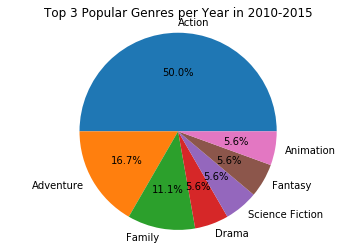

In [38]:
labels = Top3Genres.loc[:1].unique().tolist()
count = Top3Genres.loc[:2].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(count, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Top 3 Popular Genres per Year in 2010-2015')
plt.show()

Now I will look at the profit margin by taking the top three profitable movies per year and combine into one file

In [39]:
TPP10 = movies10.nlargest(3,['profit'])
TPP11 = movies11.nlargest(3,['profit'])
TPP12 = movies12.nlargest(3,['profit'])
TPP13 = movies13.nlargest(3,['profit'])
TPP14 = movies14.nlargest(3,['profit'])
TPP15 = movies15.nlargest(3,['profit'])
TopProfitable = pd.concat([TPP10,TPP11,TPP12,TPP13,TPP14,TPP15],axis=0, sort=False)
TopProfitable

,id,popularity,budget,revenue,original_title,director,genres,production_companies,release_year,profit
1930,10193,2.711136,200000000,1063171911,Toy Story 3,Lee Unkrich,Animation,Walt Disney Pictures,2010,863171911
1921,12155,5.572950,200000000,1025467110,Alice in Wonderland,Tim Burton,Family,Walt Disney Pictures,2010,825467110
1923,12444,4.840588,250000000,954305868,Harry Potter and the Deathly Hallows: Part 1,David Yates,Adventure,Warner Bros.,2010,704305868
3374,12445,5.711315,125000000,1327817822,Harry Potter and the Deathly Hallows: Part 2,David Yates,Adventure,Warner Bros.,2011,1202817822
3522,38356,0.760503,195000000,1123746996,Transformers: Dark of the Moon,Michael Bay,Action,Paramount Pictures,2011,928746996
3375,1865,4.955130,380000000,1021683000,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,Adventure,Walt Disney Pictures,2011,641683000
4361,24428,7.637767,220000000,1519557910,The Avengers,Joss Whedon,Science Fiction,Marvel Studios,2012,1299557910
4365,37724,5.603587,200000000,1108561013,Skyfall,Sam Mendes,Action,Columbia Pictures,2012,908561013
4363,49026,6.591277,250000000,1081041287,The Dark Knight Rises,Christopher Nolan,Action,Legendary Pictures,2012,831041287
5422,109445,6.112766,150000000,1274219009,Frozen,Chris Buck|Jennifer Lee,Animation,Walt Disney Pictures,2013,1124219009


Plot a pie chart of the top 3 profitable movies per year by genre

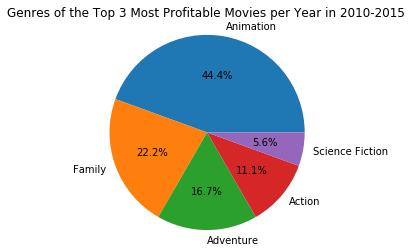

In [40]:
labels = TopProfitable.iloc[:,6].unique().tolist()
TPGenres = TopProfitable.iloc[:,6].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(TPGenres, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Genres of the Top 3 Most Profitable Movies per Year in 2010-2015')
plt.show()

MOST PROFITABLE LIST OF MOVIES 2010-2015

In [47]:
TopProfitable['original_title']

1930                                     Toy Story 3
1921                             Alice in Wonderland
1923    Harry Potter and the Deathly Hallows: Part 1
3374    Harry Potter and the Deathly Hallows: Part 2
3522                  Transformers: Dark of the Moon
3375     Pirates of the Caribbean: On Stranger Tides
4361                                    The Avengers
4365                                         Skyfall
4363                           The Dark Knight Rises
5422                                          Frozen
5425                                      Iron Man 3
5434                                 Despicable Me 2
634        The Hobbit: The Battle of the Five Armies
633            The Hunger Games: Mockingjay - Part 1
630                          Guardians of the Galaxy
3                       Star Wars: The Force Awakens
0                                     Jurassic World
4                                          Furious 7
Name: original_title, dtype: object

MOST POPULAR LIST OF MOVIES 2010-2015

In [42]:
TopPopular['original_title']

1919                              Inception
1920                             Iron Man 2
1921                    Alice in Wonderland
3371                Underworld: Endless War
3372     Captain America: The First Avenger
3373                                  Drive
4361                           The Avengers
4362                  Underworld: Awakening
4363                  The Dark Knight Rises
5422                                 Frozen
5423                                Gravity
5424                   Thor: The Dark World
629                            Interstellar
630                 Guardians of the Galaxy
631     Captain America: The Winter Soldier
0                            Jurassic World
1                        Mad Max: Fury Road
2                                 Insurgent
Name: original_title, dtype: object

What movies are both Popular and Profitable 

In [43]:
set(TopPopular['original_title']) & set(TopProfitable['original_title'])

{'Alice in Wonderland',
 'Frozen',
 'Guardians of the Galaxy',
 'Jurassic World',
 'The Avengers',
 'The Dark Knight Rises'}

What are the genres of the movies that are both Popular and Profitable

In [48]:
set(TopPopular['genres']) & set(TopProfitable['genres'])

{'Action', 'Adventure', 'Animation', 'Family', 'Science Fiction'}

# 18 Most Popular Genres Over 6 Years (2010-2015)

This is NOT 3 from each year. It is overall popularity from the 6 years.

In [54]:
moviesPopular2010_2015 = moV2010_2015.nlargest(18,['popularity'])
moviesPopularGenres2010_2015 = moV2010_2015.nlargest(18,['popularity']).genres

18 Most Profitable Genres Over 6 Years (2010-2015)

In [55]:
moviesProfitable2010_2015 = moV2010_2015.nlargest(18,['profit'])
moviesProfitableGenres2010_2015 = moV2010_2015.nlargest(18,['profit']).genres

What movies are both Popular and Profitable  Over 6 Years (2010-2015)

In [57]:
set(moviesPopular2010_2015['original_title']) & set(moviesProfitable2010_2015['original_title'])

{'Furious 7', 'Jurassic World', 'Star Wars: The Force Awakens'}

Movie Genres that were Both Popular and Profitable

In [56]:
set(moviesPopularGenres2010_2015) & set(moviesProfitableGenres2010_2015)

{'Action', 'Adventure', 'Science Fiction'}

Just for fun, let's look at what year produced the largest amount of  most popular movies

In [66]:
overall_popular = moV.nlargest(18,['popularity']).release_year

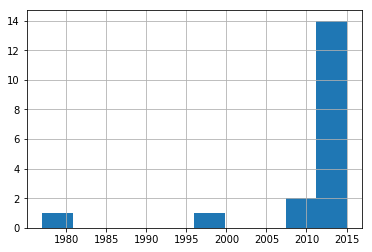

In [67]:
overall_popular.hist()

In [ ]:
MOST POPULAR GENRES OF ENTIRE DATA SET THAT WERE BOTH POPULAR AND PROFITABLE

In [60]:
OverallPopularEntireFile = moV.nlargest(18,['popularity'])
OverallPopularGenresEntireFile = moV.nlargest(18,['popularity']).genres

In [61]:
OverallProfitableEntireFile = moV.nlargest(18,['profit'])
OverallProfitableGenresEntireFile = moV.nlargest(18,['profit']).genres

GENRES THAT WERE BOTH POPULAR AND PROFITABLE

In [62]:
set(OverallPopularEntireFile['original_title']) & set(OverallProfitableEntireFile['original_title'])

{'Avatar', 'Furious 7', 'Jurassic World', 'Star Wars: The Force Awakens'}

MOVIES THAT WERE BOTH POPULAR AND PROFITABLE

In [63]:
set(OverallPopularGenresEntireFile) & set(OverallProfitableGenresEntireFile)

{'Action', 'Adventure', 'Drama', 'Science Fiction'}

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

### Limitation
> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

## OPTIONAL: Question for the reviewer
 
If you have any question about the starter code or your own implementation, please add it in the cell below. 

For example, if you want to know why a piece of code is written the way it is, or its function, or alternative ways of implementing the same functionality, or if you want to get feedback on a specific part of your code or get feedback on things you tried but did not work.

Please keep your questions succinct and clear to help the reviewer answer them satisfactorily. 

> **_Your question_**

1) This was noted in the comments the first time a bar graph was made. I see there is an issue with the spacing for the x-labels. I cannot come up with a reason.
2) I struggled to make a function that  splits the movie file into seperate dataframes. If you could help or point me to a reference...
3) I used a 'pad = 35' on my pie charts when I worked on my computer but when I put it in Udacity's Jupyter, it gave an error. Is there a workaround?